# BENG227 Final Project Visualization Notebook

This jupyter notebook creates all the new figures used in the final project for BENG227 Transport Phenomena.

To generate the data need for this script please run the included python scipt with the following calls:

Merge the csvs produced from the following into "sim.6000.240.csv":
<pre><code>
python ./drug_diffusion.py --time 6000 --delivery_time 240 --model default
python ./drug_diffusion.py --time 6000 --delivery_time 240 --model vafai4
</code></pre>


Merge the csvs produced from the following into "./sim.1000.900.csv":
<pre><code>
python ./drug_diffusion.py --time 1000 --delivery_time 900 --model default
python ./drug_diffusion.py --time 1000 --delivery_time 900 --model vafai4
</code></pre>



Merge the csvs produced from the following into "./sim.4000.3600.csv":
<pre><code>
python ./drug_diffusion.py --time 4000 --delivery_time 3600 --model default
python ./drug_diffusion.py --time 4000 --delivery_time 3600 --model vafai4
</code></pre>


Merge the csvs produced from the following into "./sim.15000.14400.csv"
<pre><code>
python ./drug_diffusion.py --time 15000 --delivery_time 14400 --model default
python ./drug_diffusion.py --time 15000 --delivery_time 14400 --model vafai4
</code></pre>

You will also need literature values from Figure 2A in 
Creel et al
"Arterial Paclitaxel Distribution and Decomposion"
Integrative Physiology



Brenton Munson and Jonathan Pekar 
University of California San Diego
Department of Bioengineering
June 12, 2017

correspondance: bpmunson@ucsd.edu

## Imports

In [12]:
import numpy as np
import pandas as pd
import pickle

time: 3.51 ms


In [13]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
time: 2.81 ms


In [14]:
%%R
library(plyr)
library(ggplot2)
library(reshape2)
library(tidyr)

time: 13.7 ms


In [15]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 25.5 ms


# Submisson Plots

## Get Data

In [16]:
# Read in stored data files
data_path = "t_2000_d_240_A.sim.data.csv"
data_path = "sim.6000.240.csv"
data = pd.read_csv(data_path, index_col=0,header=0)

/usr/local/lib/python3.4/dist-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 4.98 s


In [17]:
%Rpush data

time: 1min 1s


## Donut plot

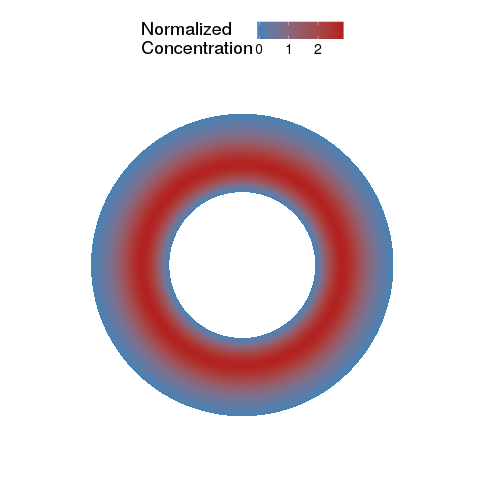

time: 4.73 s


In [66]:
%%R

# get concentration in the radius for just last time point 
df = subset(data, data$time == 1200)

# apply a group to the data and subset on only the multiwall tissue
# get only the concentration in multi tissue 
df$group = paste(df$model, df$medium, sep="_")
df = subset(df, df$model == "vafai4")
df = subset(df, df$medium == "tissue")

# add an offset to the radius for the lumn
df$radius = 200 + df$radius

# construct the ggplot graphic
g = ggplot(df, aes( y=radius,
                    x=group,
                    fill=concentration))+
    geom_tile()+
    theme_bw(base_size=18, base_family="Helvetica")+
    ylim(c(0,max(df$radius)+20))+
    coord_polar(theta="x")+
    scale_fill_gradient(low="steelblue",high="firebrick")+
    labs(fill="Normalized\nConcentration")+
    theme(panel.background=element_blank(),
          panel.border =element_blank(),
          axis.text.y=element_blank(),
           axis.title=element_blank(),
           panel.grid=element_blank(),
           #axis.text.x=element_blank(),
           axis.ticks=element_blank(),
         legend.position="top")

# display and write the plot to disk
print(g)
ggsave("./donut_concentration.200seconds_vafai4_240treatmentTime.png", g, width=6, height=6, dpi=600)

## Psuedo Surface Plot

In [19]:
%%R

# subset data to just the tissue and multicomparment model
df = subset(data, data$medium=="tissue")
df = subset(df, df$model=="vafai4")
# add a column for during or post drug delivery
df$delivery = 'No'
df$delivery[df$time<delivery_time]="Yes"

# subset to only after delivery times
df = subset(df, df$delivery == "No")

# make plot of drug across radius for a bunch of times
g = ggplot(df, aes( x=radius,
                    y=concentration,
                    group=time,
                    color=time))+
    geom_line(alpha=0.3)+
    scale_color_gradient(high="red",low="blue")+
    #facet_wrap(~delivery, scales="free", nrow=1)+
    theme_bw()+#xlim(0,50)+#ylim(0,3)+
    labs(y="Normalized Concentration of Drug in Tissue", color="Time",
         x = expression(paste("Depth in the Arterial Wall [",mu,"m]",sep="")))
    
# display and write the plot to disk
print(g)
ggsave("./tmp.concentration_time_line.png", g, width=6, height=6, dpi=600)


Error in df$delivery[df$time < delivery_time] = "Yes" : 
  object 'delivery_time' not found
time: 1.14 s


/usr/local/lib/python3.4/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in df$delivery[df$time < delivery_time] = "Yes" : 
  object 'delivery_time' not found

  warnings.warn(x, RRuntimeWarning)


## Line graphs of various times for 2/4-minute delivery

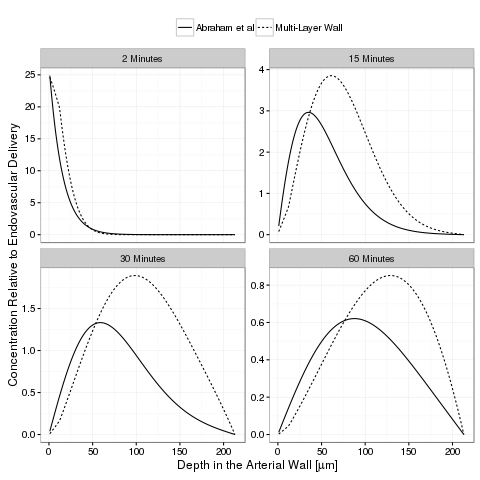

time: 3.19 s


In [64]:
%%R

# define the times of interest
times_m =  c(2,15,30,60)
times =times_m*60

# subset for just the tissue
df = subset(data, data$medium == "tissue")

# get concentration in the radius for time points
df = subset(df, df$time %in% times )

# force factorization of time
df$time = as.factor(df$time)

# clean up mysterious NA rows
df = df[!is.na(df$model),]

# relevel the model so it displays better
df$model = factor(df$model, labels=c("Abraham et al", "Multi-Layer Wall"))

# relevel the time so it displays in the facets better
levels(df$time)<-c(paste(times_m, "Minutes", sep=" "))

# plot the concentration as a function of radius
g = ggplot(df, aes( x=radius,
                    y=concentration,
                    linetype=model,
                    #color=time,
                    group=paste(time, model)))+
    geom_line()+
    facet_wrap(~time, scales="free_y")+
    theme_bw()+xlim(1,214)+
    labs(x = expression(paste("Depth in the Arterial Wall [",mu,"m]",sep="")),
         y = "Concentration Relative to Endovascular Delivery",
         linetype=NULL)+
    theme(legend.position="top")

# display and write the plot to disk
print(g)
ggsave("./concentration_time_panel.png", g, width=6, height=6, dpi=600)

## Comparison to Literature

In [49]:
%%R


# read in literature values
literature = "./creel_2000_figure_2a_data.csv"
literature = read.table(literature, header=T, sep=",")

# temporarilly subset out 4 hours
#literature = subset(literature, literature$time!=14400)

# read in model data
s15 = "./sim.1000.900.csv"
s15 = read.table(s15, header=TRUE, sep=",")
s15 = subset(s15, s15$time==900)
s60 = "./sim.4000.3600.csv"
s60 = read.table(s60, header=TRUE, sep=",")
s60 = subset(s60, s60$time==3600)
s240 = "./sim.15000.14400.csv"
s240 = read.table(s240, header=TRUE, sep=",")
s240 = subset(s240, s240$time==14400)

# combine the model data
sim = rbind(s15,s60,s240)

# subset to only tissue
sim = subset(sim, sim$medium=="tissue")

# reset the labels for easy plotting
sim$model = factor(sim$model, labels=c("Abraham et al", "Multi-Layer Wall"))
sim$time = factor(sim$time, labels=c("15 Minutes", "1 Hour", "4 Hours"))
literature$time = factor(literature$time, labels=c("15 Minutes", "1 Hour", "4 Hours"))
   

time: 21.7 s


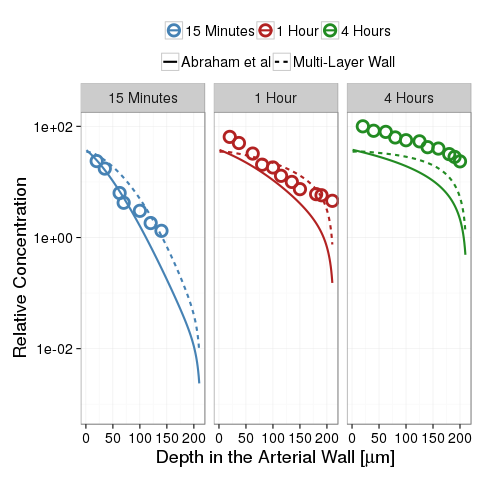

time: 1.65 s


In [65]:
%%R
# construct the graphic
g = ggplot()+
    geom_point(data=literature, aes(x=x,
                                    y=y,
                                    color=factor(time)),
              size=4, shape=1, stroke=2)+
    geom_line(data=sim, aes(x=radius, y=concentration,
                            color=factor(time),
                            linetype=model,
                            group=paste(time, model)),
             size=1)+
    xlim(1,210)+
    scale_y_log10()+
    #scale_shape_manual(values=c(0,1))+
    scale_color_manual(values=c("steelblue","firebrick","forestgreen"))+
    labs(x = expression(paste("Depth in the Arterial Wall [",mu,"m]",sep="")),
         y = "Relative Concentration",
         linetype=NULL, color=NULL)+
    guides(shape=FALSE)+
    facet_wrap(~time)+
    theme_bw(base_size=18,base_family="Helvetica")+
    theme(legend.position="top")

# display and write the plot to disk
print(g)
ggsave("./comparison_to_literature.png", g, width=6, height=6, dpi=600)